In [458]:
# os → for working with directories and file paths.

# tarfile → for opening and extracting .tgz files (tar + gzip archives).

# urllib → for downloading files from the internet.

import os
import tarfile
import urllib

# DOWNLOAD_ROOT → Base URL where the dataset is hosted (GitHub repo).
# HOUSING_PATH → Local folder where the dataset will be stored (datasets/housing).
# HOUSING_URL → Full download link for the dataset file (housing.tgz).
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # Creates the folder datasets/housing.
    # exist_ok=True → doesn’t raise an error if the folder already exists.
    os.makedirs(housing_path, exist_ok=True)

    # Builds the path for saving the downloaded archive: datasets/housing/housing.tgz.
    # Downloads the .tgz file from GitHub and saves it at that location.
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)

    # Opens the .tgz file.
    # Extracts its contents into the datasets/housing folder.
    # In this dataset, the archive contains just housing.csv
    # filter="data" (introduced in Python 3.11) → extra security to only extract safe files.
    # Closes the archive.
    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path,filter="data")
    housing_tgz.close()

In [459]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# downloads and extracts housing.tgz → housing.csv
# loads it into a Pandas DataFrame

fetch_housing_data() 
housing = load_housing_data()   

# housing.head() shows the first 5 rows
# housing.head()
# housing["ocean_proximity"].value_counts()   → counts each category in this column

# summary statistics for all numeric columns:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


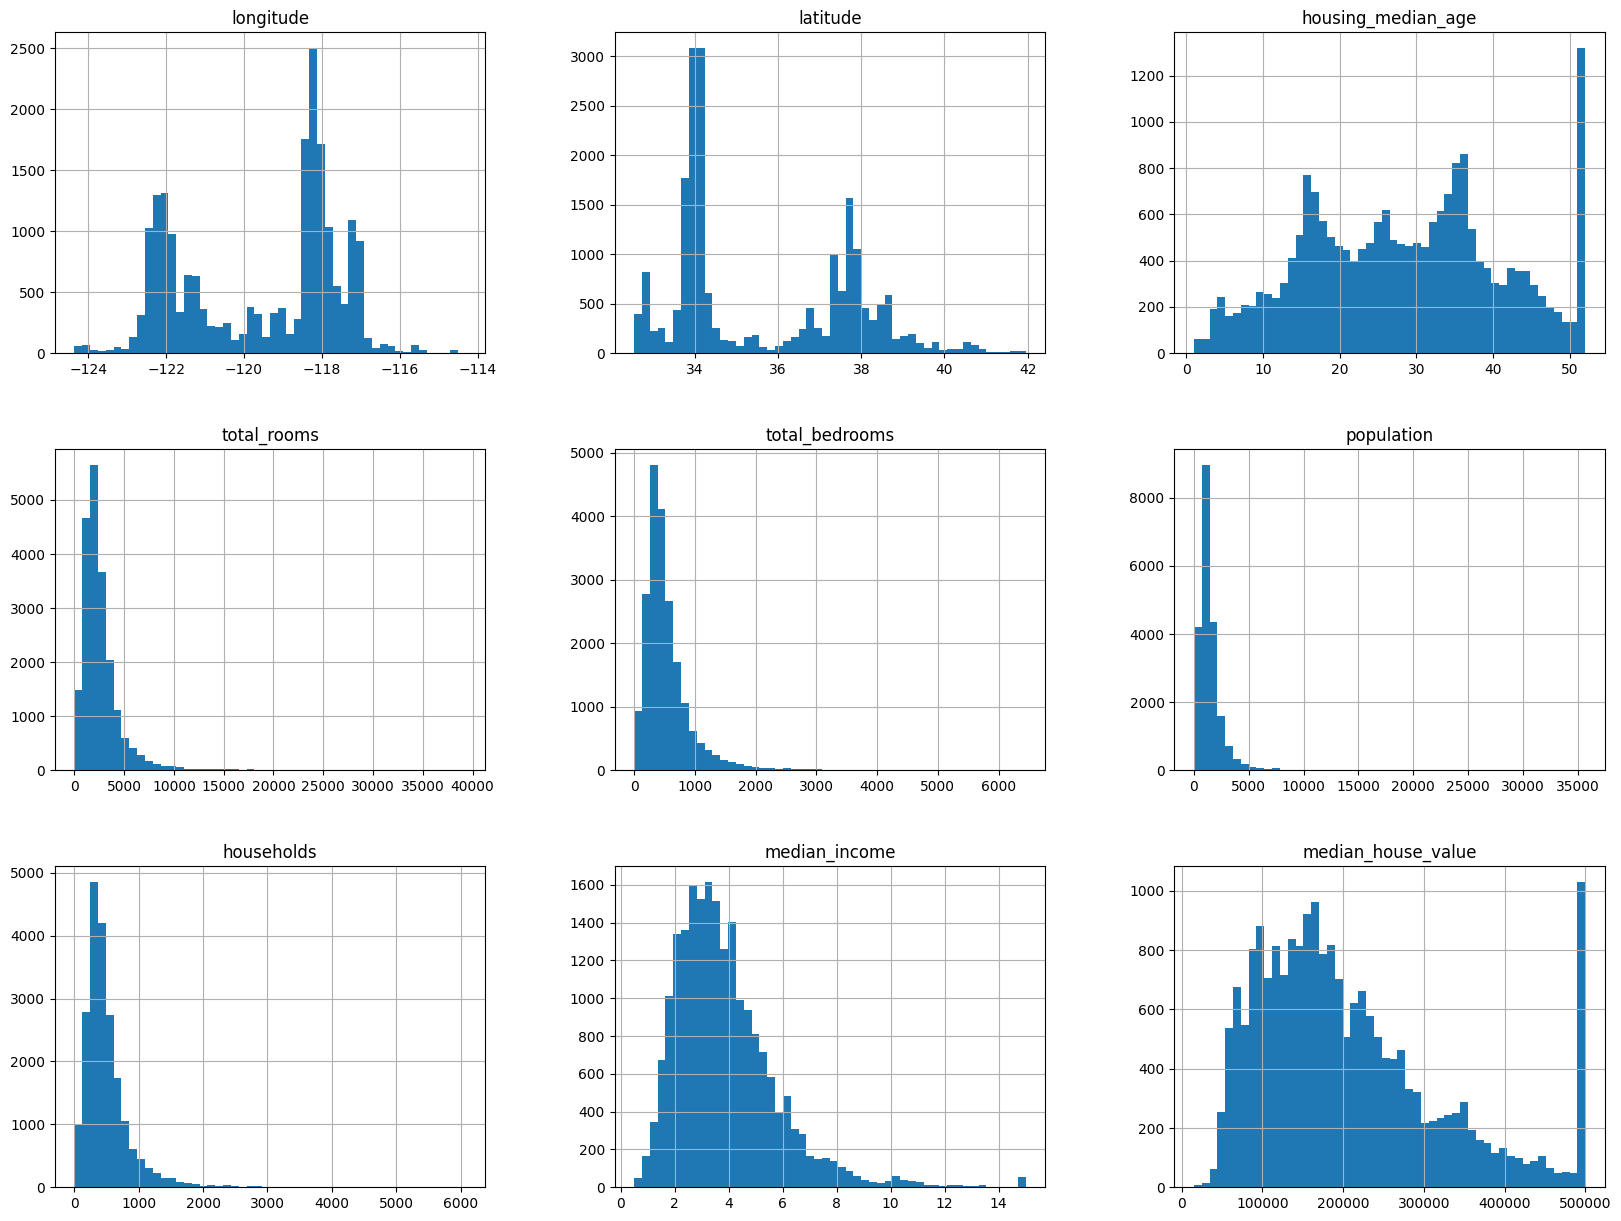

In [460]:
# A Jupyter Notebook magic command.
# Ensures that all plots (matplotlib) are displayed inside the notebook (not in a separate window).

# housing.hist(...) → creates histograms for all numeric columns in the DataFrame.

# bins=50 → divides the range of each variable into 50 intervals (more bins = more detail).

# figsize=(20,15) → sets a large figure size so all histograms are clear.

# plt.show() → renders the plots.
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [461]:
# TEST SET

import numpy as np

def split_train_set(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_set(housing, 0.2)
len(train_set)

16512

In [462]:
len(test_set)

4128

In [463]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


<Axes: >

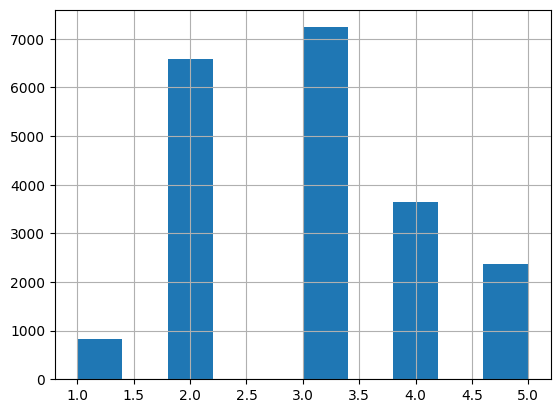

In [464]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# pd.cut() bins the continuous median_income into 5 categories:

# 1: very low income (0 – 1.5)

# 2: low income (1.5 – 3.0)

# 3: moderate (3.0 – 4.5)

# 4: high (4.5 – 6.0)

# 5: very high (6.0+)

# This is done so we can later stratify the train/test split — ensuring income distribution is preserved in both sets.
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist()

In [465]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

<Axes: xlabel='longitude', ylabel='latitude'>

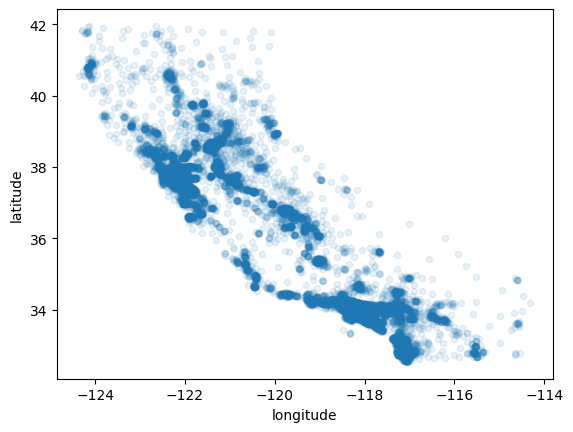

In [466]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

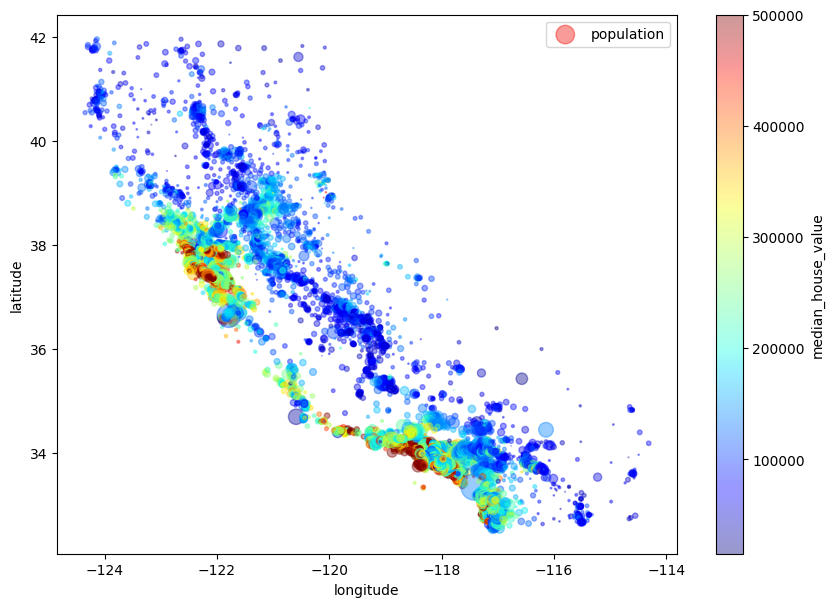

In [467]:
# longitude vs latitude → places homes on a California map.

# alpha=0.4 → transparency so dense areas don’t hide details.

# s = population/100 → circle size ∝ population in that district.

# c = median_house_value → color encodes house price.

# cmap = "jet" → colormap (blue = low prices, red = high prices).

# colorbar=True → shows the price scale.

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            )
plt.legend()

In [468]:
#🔎 Step 1: housing.corr(numeric_only=True)

# housing is your DataFrame.

# .corr() computes the correlation coefficient between every pair of numeric columns.

# numeric_only=True ensures it only considers numerical columns (ignores categorical ones like "ocean_proximity").

# So you get a correlation matrix → a big table showing how strongly each numerical feature is related to each other. 


corr_matrix = housing.corr(numeric_only=True)

#🔎 Step 2: corr_matrix["median_house_value"]

# Now, instead of the full correlation matrix, you select only one column:

# → the correlation of every feature with median_house_value (your target).

# Sorts those correlations from highest to lowest.
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

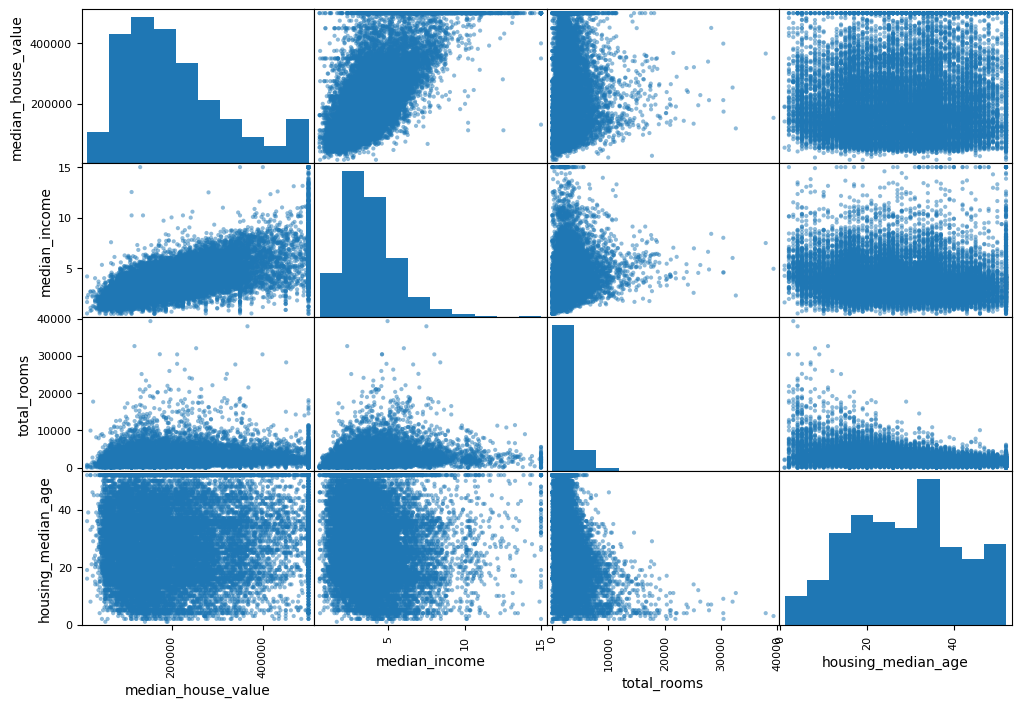

In [469]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

In [470]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

# .corr() computes the correlation coefficient between every pair of numeric columns.
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

<Axes: xlabel='median_income', ylabel='median_house_value'>

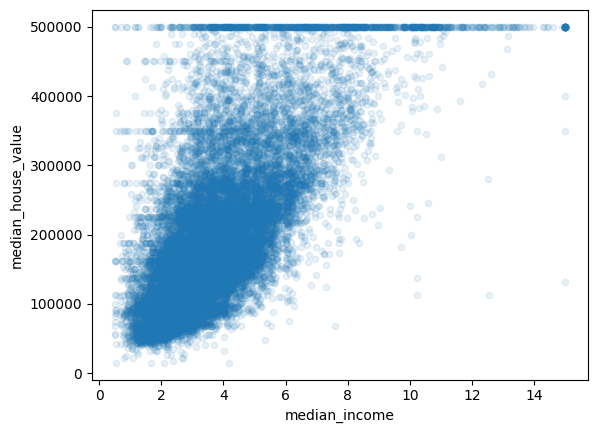

In [471]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

In [472]:
housing = strat_train_set.drop("median_house_value", axis=1)

# strat_train_set["median_house_value"].copy()

# This extracts just the target column (median_house_value) into a separate variable.

# .copy() makes a safe copy, so changes in housing_labels won’t accidentally affect the original dataset.

housing_labels = strat_train_set["median_house_value"].copy()

In [473]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY,2
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN,3
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN,3
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN,3
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN,5


In [474]:
from sklearn.impute import SimpleImputer

# You initialize a SimpleImputer.
# strategy="median" means missing values in each column will be replaced by the median of that column.

imputer = SimpleImputer(strategy="median")

# ocean_proximity is a categorical (string) column.
# Since the imputer only works with numeric data, you drop it here.
# housing_num now contains only numeric features

housing_num = housing.drop("ocean_proximity", axis=1)

# The imputer learns the median of each column and stores them.
# You can check what it learned with:
# imputer.statistics_

imputer.fit(housing_num)

# All missing values (NaN) in housing_num are replaced with the median of their column.
# Output: a NumPy array (X) with no missing values.
X = imputer.transform(housing_num)

# Wraps the clean NumPy array X back into a Pandas DataFrame.
# Keeps the original column names and row indices, so it looks just like the original housing_num but without missing values.
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [475]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [476]:
# OrdinalEncoder converts text labels into integers.

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# fit_transform does two things:
    # Fit: Learns all unique categories in housing_cat and assigns each a number.
    # Transform: Replaces the text categories with those numbers.

# "<1H OCEAN" → 0
# "INLAND"    → 1
# "ISLAND"    → 2
# "NEAR BAY"  → 3
# "NEAR OCEAN"→ 4

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [477]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [478]:
# OneHotEncoder converts each category into a separate column with 0/1 values.
from sklearn.preprocessing import OneHotEncoder

# The result (housing_cat_1hot) is a sparse matrix (efficient memory storage).
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [479]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

In [480]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [481]:
# BaseEstimator and TransformerMixin are base classes from scikit-learn that let you create custom transformers.

# BaseEstimator gives your class things like get_params() and set_params() for hyperparameter tuning.

# TransformerMixin gives your class a default implementation of fit_transform().

# rooms_ix, bedrooms_ix, population_ix, households_ix are column indices in your dataset that correspond to:

# rooms_ix = 3 → total rooms

# bedrooms_ix = 4 → total bedrooms

# population_ix = 5 → population

# households_ix = 6 → number of households

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


# This is the constructor.

# add_bedrooms_per_room is a flag:

# True → compute bedrooms_per_room

# False → skip it

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

     # fit() is required by scikit-learn but this transformer doesn’t need to learn anything from the data, so it just returns self.

     # y=None is included because some pipelines pass both X and y.
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    # Calculates two new features:

    # Rooms per household: total_rooms / households

    # Population per household: population / households

    # What X represents

    # In scikit-learn, transformers and estimators always take features (independent variables) as the first argument.

    # Here, X is expected to be a NumPy array (or something that can behave like it, e.g., housing.values).

    # Each row in X is one data instance (e.g., one house).

    # Each column in X is one feature (e.g., number of rooms, number of bedrooms, population, households, etc.).
    
    def transform(self, X):
        
    # X[:, rooms_ix] → all rows, column rooms_ix.

    # : → means all rows.

    # rooms_ix → selects that specific column.

    # / → element-wise division in NumPy.

    # The result is a NumPy array of new feature values.
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

    # np.c_[] → concatenates arrays column-wise in NumPy.

    # Adds the new features as additional columns to X.

    # return → outputs the transformed array.
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


# attr_adder = CombinedAttributesAdder(...) → create an object of the class.

# .transform(housing.values) → call the transform method on the raw data.

# housing.values → converts a Pandas DataFrame to a NumPy array.
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [482]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    # SimpleImputer(strategy="median") 
    # Fills in missing values (e.g., if some houses don’t have a total_bedrooms value, replace with the median).

    ('imputer', SimpleImputer(strategy="median")), 
    
    # CombinedAttributesAdder()
    # Adds new features like rooms_per_household, population_per_household, etc.
    ('attribs_adder', CombinedAttributesAdder()),

    # StandardScaler()
    # Standardizes numerical features → shifts them so they have mean = 0, variance = 1.
    # This prevents features with large numbers (like population) from overpowering small ones (like bedrooms_per_room).
    
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [483]:
# ColumnTransformer lets you apply different preprocessing steps to different columns.

# Numeric columns → imputation, scaling, feature engineering

# Categorical columns → one-hot encoding

from sklearn.compose import ColumnTransformer

# num_attribs → all the numeric columns (from housing_num)

# cat_attribs → the categorical column you want to encode

num_attribs = list(housing_num) 
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    
    # apply num_pipeline to numeric columns
    ("num", num_pipeline, num_attribs),         # numeric pipeline for numeric columns

    # apply OneHotEncoder to categorical column
    ("cat", OneHotEncoder(), cat_attribs),      # one-hot encoding for categorical columns
])

# "num" → name for the numeric transformer

# num_pipeline → the pipeline you defined earlier (imputer + feature adder + scaler)

# num_attribs → list of numeric columns to apply it on

# "cat" → name for the categorical transformer

# OneHotEncoder() → converts categorical values into binary columns

# cat_attribs → the categorical columns to apply it on


# Apply pipeline to the whole dataset
housing_prepared = full_pipeline.fit_transform(housing)

In [484]:
from sklearn.linear_model import LinearRegression

# Linear regression predicts a continuous target variable (here, median_house_value) as a weighted sum of the input features:
# ŷ = w1x1 + w2x2 + ... + wnxn + b

lin_reg = LinearRegression()

# fit() learns the weights w and bias  𝑏
# that minimize the squared error between predictions and actual labels.

# Input: housing_prepared → preprocessed features

# Target: housing_labels → actual median house values

lin_reg.fit(housing_prepared, housing_labels)

# Take first 5 rows of the dataset.

# Transform them using the same pipeline (important: transform(), not fit_transform()).

# Predict their median house values with lin_reg.predict().

# Compare predictions to the actual labels.

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

print("Labels:", list(some_labels))

Predictions: [ 83811.08312039 314388.27147935 145641.85902864 183704.64921202
 238729.66725745]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [485]:
from sklearn.metrics import mean_squared_error

# mean_squared_error(y_true, y_pred) → average of squared differences between predicted and actual values:

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)

# np.sqrt(lin_mse) → root mean squared error (RMSE), which is in the same units as the target variable (e.g., dollars).
# RMSE is a common metric to measure how well a regression model predicts values.

lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(68376.51254853733)

In [513]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)

tree_rmse = np.sqrt(tree_mse)

tree_rmse

np.float64(0.0)

In [514]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)


Scores: [71514.09514749 69776.00060169 68747.5323188  71178.33903876
 69810.62050022 78007.32418707 70996.26853672 72816.15835642
 67763.38339258 70957.30292275]
Mean: 71156.70250024965
Standard deviation: 2662.996397668597


In [515]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71523.78333874 64044.46774989 67454.97869698 68514.10137273
 66303.62531226 72166.63405138 74464.08841381 68570.11804395
 66063.64175868 69870.86192291]
Mean: 68897.63006613276
Standard deviation: 3002.746127534861


In [516]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)

forest_mse = mean_squared_error(housing_labels, housing_predictions)

forest_rmse = np.sqrt(forest_rmse)

forest_rmse

np.float64(1.8488665511568296)

In [517]:
display_scores(forest_rmse_scores)

Scores: [51612.6795374  48825.95719474 46800.53700502 52045.62482917
 47200.06751237 51985.78325696 52649.47459047 49343.35285417
 48634.37916917 53784.13624506]
Mean: 50288.19921945133
Standard deviation: 2301.91515545915


In [521]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)



grid_search.best_estimator_

,n_estimators,30
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [522]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

,estimator,RandomForestRegressor()
,param_grid,"[{'max_features': [2, 4, ...], 'n_estimators': [3, 10, ...]}, {'bootstrap': [False], 'max_features': [2, 3, ...], 'n_estimators': [3, 10]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,30


In [523]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# In this example, we obtain the best solution by setting the max_features hyperpara‐
# meter to 8 and the n_estimators hyperparameter to 30. The RMSE score for this
# combination is 49,682, which is slightly better than the score you got earlier using the

63666.12926696535 {'max_features': 2, 'n_estimators': 3}
55578.723831710064 {'max_features': 2, 'n_estimators': 10}
52914.34989648302 {'max_features': 2, 'n_estimators': 30}
60691.52440221187 {'max_features': 4, 'n_estimators': 3}
53520.92385819101 {'max_features': 4, 'n_estimators': 10}
51493.29073678681 {'max_features': 4, 'n_estimators': 30}
60011.57883770103 {'max_features': 6, 'n_estimators': 3}
52563.93950370907 {'max_features': 6, 'n_estimators': 10}
50827.67731190384 {'max_features': 6, 'n_estimators': 30}
58872.734219048616 {'max_features': 8, 'n_estimators': 3}
52781.80853434882 {'max_features': 8, 'n_estimators': 10}
50610.935091275605 {'max_features': 8, 'n_estimators': 30}
62517.5071559196 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54616.23602793978 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60081.64118963316 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53148.46953633351 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [524]:
grid_search.best_estimator_

,n_estimators,30
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,8
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [525]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [526]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 